# MNISTの3層ネットワーク

In [1]:
# パッケージの読み込み
using Flux
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold
using Flux.Losses: logitcrossentropy
using MLDatasets

# データセットの読み込み
x_train, y_train = MLDatasets.MNIST.traindata(Float32)
x_test, y_test = MLDatasets.MNIST.testdata(Float32)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\stone\.julia\packages\MLDatasets\268Pz\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\stone\.julia\packages\MLDatasets\268Pz\src\datasets\vision\mnist.jl:195


(features = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

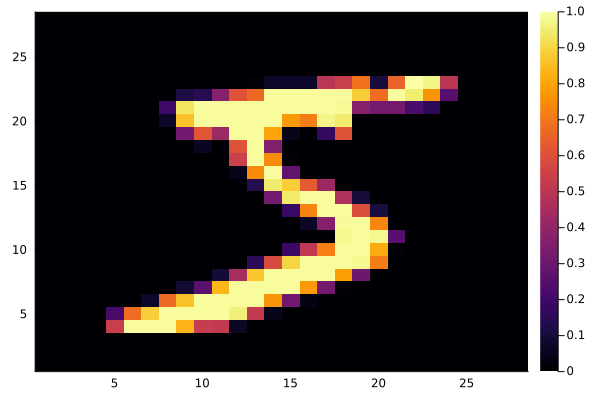

In [2]:
# データの可視化
using Plots
heatmap(rotl90(x_train[1:28, 1:28, 1])) # そのままだと横向きに表示されてしまうので、rotl90で行列を右に90度回転させる

In [3]:
x_train[1:28, 1:28, 1]

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.0        0.0  0.0  0.0
 ⋮

In [3]:
# データを(サンプル数×特徴量の個数)に変換する

## 訓練データ
flatten_x_train = transpose(Flux.flatten(x_train)) # 60,000×784
### 60,000枚の画像だと多すぎるので、最初の1,000枚だけを使う
flatten_x_train = flatten_x_train[1:1000, :]

## テストデータ
flatten_x_test = transpose(Flux.flatten(x_test)) # 10,000×784
### 10,000枚の画像だと多すぎるので、最初の1,000枚だけを使う
flatten_x_test = flatten_x_test[1:1000, :]

1000×784 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [4]:
# one-hot-labelへの変換
## 訓練データ
one_hot_label_y_train =  permutedims(onehotbatch(y_train, 0:9)) # 60,000×10
### 60,000枚の画像だと多すぎるので、最初の1,000枚だけを使う
one_hot_label_y_train = one_hot_label_y_train[1:1000, :]

## テストデータ
one_hot_label_y_test = permutedims(onehotbatch(y_test, 0:9)) # 10,000×10
### 10,000枚の画像だと多すぎるので、最初の1,000枚だけを使う
one_hot_label_y_test = one_hot_label_y_test[1:1000, :]

1000×10 Matrix{Bool}:
 0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  1
 ⋮              ⋮           
 0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 1  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1

In [5]:
using LinearAlgebra, Statistics, Random
"""
データ
    訓練データ(特徴量)：flatten_x_train
    訓練データ(目的変数)：one_hot_label_y_train
"""

"""
パラメータ
"""
# 学習率
α = 0.005

# 入力層のサイズ
input_size = size(flatten_x_train)[2] # 784

# 隠れ層のサイズ
hidden_size = 300

# 出力層のサイズ
output_size = 10

W_0_1 = 0.2*rand(input_size, hidden_size).-0.1
W_1_2 = 0.2*rand(hidden_size, output_size).-0.1

# イテレーション
max_iteration = 1

"""
関数
"""
relu(x) = (x>0)*x

relu2deriv(output) = output>0


"""
誤差逆伝播法
"""
# MSEを保存する用のリストを作成
mse_list = []

for iteration=1:max_iteration
    for index=1:size(flatten_x_train)[1]
        # 順伝播
        layer_0 = flatten_x_train[index, :]' # flatten_x_train[index, :]は横ベクトルで値を取得したはずが、縦ベクトルに勝手に変換されてしまう。そのため転置を行っている。
        layer_1_1 = layer_0*W_0_1 # 中間層の活性化関数に入れる前
        layer_1_2 = relu.(layer_1_1) # 中間層の活性化関数に入れた後
        layer_2 = layer_1_2*W_1_2
            
        # 更新式の差分
        ## layer_2のパラメータの更新式の差分
        ### layer_2ではなく、layer_2[1]としているのは、layer2が(1, 1)の行列になっているから
        layer_2_delta = layer_2-one_hot_label_y_train[index, :]'
        W_1_2_delta = α*layer_1_2'*layer_2_delta
        
        ## layer_1のパラメータの更新式の差分
        W_0_1_delta = α*reshape(layer_0, 1, 784)'*(W_1_2*layer_2_delta'.*relu2deriv.(layer_1_1'))'

        # 更新
        W_1_2 = W_1_2-W_1_2_delta        
        W_0_1 = W_0_1-W_0_1_delta
        
    end
    
    # MSE(Mean Square Error)の計算
    ## 全てのデータに対して順伝播を行う
    Layer_1_1 = flatten_x_train*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2 = relu.(Layer_1_1) # 中間層の活性化関数に入れた後
    pred_list = Layer_1_2*W_1_2
    

    mse = mean((pred_list-one_hot_label_y_train).^2)
    push!(mse_list, mse)
    println("Error:", mse)
        
end

Error:0.04145716560070847


# そう難しいことではない

In [6]:
using LinearAlgebra, Statistics, Random
"""
データ
    訓練データ(特徴量)：flatten_x_train
    訓練データ(目的変数)：one_hot_label_y_train
"""

"""
パラメータ
"""
# 学習率
α = 0.005

# 入力層のサイズ
input_size = size(flatten_x_train)[2] # 784

# 隠れ層のサイズ
hidden_size = 300

# 出力層のサイズ
output_size = 10

W_0_1 = 0.2*rand(input_size, hidden_size).-0.1
W_1_2 = 0.2*rand(hidden_size, output_size).-0.1

# イテレーション
max_iteration = 100

"""
関数
"""
relu(x) = (x>0)*x

relu2deriv(output) = output>0


"""
誤差逆伝播法
"""
# MSEを保存する用のリストを作成
mse_train_list = []
mse_test_list = []

for iteration=1:max_iteration
    for index=1:size(flatten_x_train)[1]
        # 順伝播
        layer_0 = flatten_x_train[index, :]' # flatten_x_train[index, :]は横ベクトルで値を取得したはずが、縦ベクトルに勝手に変換されてしまう。そのため転置を行っている。
        layer_1_1 = layer_0*W_0_1 # 中間層の活性化関数に入れる前
        layer_1_2 = relu.(layer_1_1) # 中間層の活性化関数に入れた後
        layer_2 = layer_1_2*W_1_2
            
        # 更新式の差分
        ## layer_2のパラメータの更新式の差分
        ### layer_2ではなく、layer_2[1]としているのは、layer2が(1, 1)の行列になっているから
        layer_2_delta = layer_2-one_hot_label_y_train[index, :]'
        W_1_2_delta = α*layer_1_2'*layer_2_delta # 次はここから直す
        
        ## layer_1のパラメータの更新式の差分
        W_0_1_delta = α*reshape(layer_0, 1, 784)'*(W_1_2*layer_2_delta'.*relu2deriv.(layer_1_1'))'

        # 更新
        W_1_2 = W_1_2-W_1_2_delta        
        W_0_1 = W_0_1-W_0_1_delta
        
    end
    
    # MSE(Mean Square Error)の計算
    ## 全てのデータに対して順伝播を行う
    ### 訓練データ
    Layer_1_1_train = flatten_x_train*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2_train = relu.(Layer_1_1_train) # 中間層の活性化関数に入れた後
    pred_list_train = Layer_1_2_train*W_1_2
    
    mse_train = mean((pred_list_train-one_hot_label_y_train).^2)
    push!(mse_train_list, mse_train)
        
    ### テストデータ
    Layer_1_1_test = flatten_x_test*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2_test = relu.(Layer_1_1_test) # 中間層の活性化関数に入れた後
    pred_list_test = Layer_1_2_test*W_1_2
    
    mse_test = mean((pred_list_test-one_hot_label_y_test).^2)
    push!(mse_test_list, mse_test)
        
end

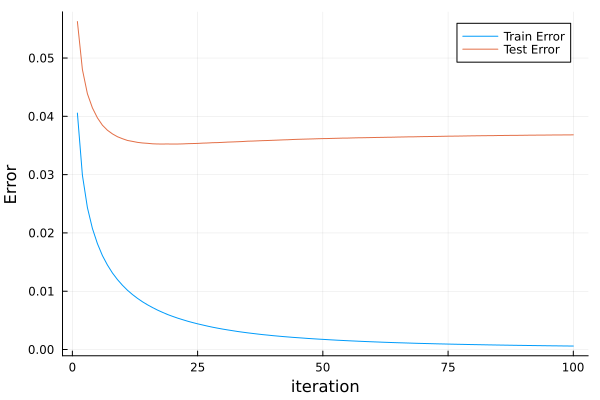

In [7]:
using Plots
plot(1:max_iteration, mse_train_list, label="Train Error", xlabel="iteration", ylabel="Error")
plot!(1:max_iteration, mse_test_list, label="Test Error", xlabel="iteration", ylabel="Error")

In [12]:
# 結果の出力
using Pkg
Pkg.add("CSV")

using CSV
CSV.write("mse_train_list.csv", mse_train_list)
CSV.write("mse_test_list.csv", mse_test_list)

    Updating registry at `C:\Users\stone\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\stone\.julia\environments\v1.9\Project.toml`
  [336ed68f] + CSV v0.10.11
  No Changes to `C:\Users\stone\.julia\environments\v1.9\Manifest.toml`


LoadError: ArgumentError: 'Vector{Any}' iterates 'Float64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

# 記憶と汎化
スクリプトなし

# ニューラルネットワークの過学習
スクリプトなし

# 過学習の原因
スクリプトなし

# 最も単純な正則化：早期終了
スクリプトなし

# 業界標準の正則化：ドロップアウト
スクリプトなし

# ドロップアウトは疑似的なアンサンブル学習
スクリプトはなし

# ドロップアウトのコード

In [8]:
using LinearAlgebra, Statistics, Random
"""
データ
    訓練データ(特徴量)：flatten_x_train
    訓練データ(目的変数)：one_hot_label_y_train
"""

"""
パラメータ
"""
# 学習率
α = 0.005

# 入力層のサイズ
input_size = size(flatten_x_train)[2] # 784

# 隠れ層のサイズ
hidden_size = 300

# 出力層のサイズ
output_size = 10

W_0_1 = 0.2*rand(input_size, hidden_size).-0.1
W_1_2 = 0.2*rand(hidden_size, output_size).-0.1

# イテレーション
max_iteration = 100

"""
関数
"""
relu(x) = (x>0)*x

relu2deriv(output) = output>0


"""
誤差逆伝播法
"""
# MSEを保存する用のリストを作成
mse_train_dropout_list = []
mse_test_dropout_list = []

for iteration=1:max_iteration
    for index=1:size(flatten_x_train)[1]
        # 順伝播
        layer_0 = flatten_x_train[index, :]' # flatten_x_train[index, :]は横ベクトルで値を取得したはずが、縦ベクトルに勝手に変換されてしまう。そのため転置を行っている。
        layer_1_1 = layer_0*W_0_1 # 中間層の活性化関数に入れる前
        layer_1_2 = relu.(layer_1_1) # 中間層の活性化関数に入れた後
        
        # Dropoutを行う
        dropout_mask = reshape(rand(0:2, size(layer_1_2)[2]), 1, size(layer_1_2)[2])
        layer_1_2 = layer_1_2.*dropout_mask
        
        layer_2 = layer_1_2*W_1_2
            
        # 更新式の差分
        ## layer_2のパラメータの更新式の差分
        ### layer_2ではなく、layer_2[1]としているのは、layer2が(1, 1)の行列になっているから
        layer_2_delta = layer_2-one_hot_label_y_train[index, :]'
        W_1_2_delta = α*layer_1_2'*layer_2_delta # 次はここから直す
        
        ## layer_1のパラメータの更新式の差分
        layer_1_delta = (W_1_2*layer_2_delta'.*relu2deriv.(layer_1_1'))'
        layer_1_delta = layer_1_delta.*dropout_mask
        W_0_1_delta = α*reshape(layer_0, 1, 784)'*layer_1_delta

        # 更新
        W_1_2 = W_1_2-W_1_2_delta        
        W_0_1 = W_0_1-W_0_1_delta
        
    end
    
    # MSE(Mean Square Error)の計算
    ## 全てのデータに対して順伝播を行う
    ### 訓練データ
    Layer_1_1_train = flatten_x_train*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2_train = relu.(Layer_1_1_train) # 中間層の活性化関数に入れた後
    pred_list_train = Layer_1_2_train*W_1_2
    
    mse_train = mean((pred_list_train-one_hot_label_y_train).^2)
    push!(mse_train_dropout_list, mse_train)
        
    ### テストデータ
    Layer_1_1_test = flatten_x_test*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2_test = relu.(Layer_1_1_test) # 中間層の活性化関数に入れた後
    pred_list_test = Layer_1_2_test*W_1_2
    
    mse_test = mean((pred_list_test-one_hot_label_y_test).^2)
    push!(mse_test_dropout_list, mse_test)
        
end

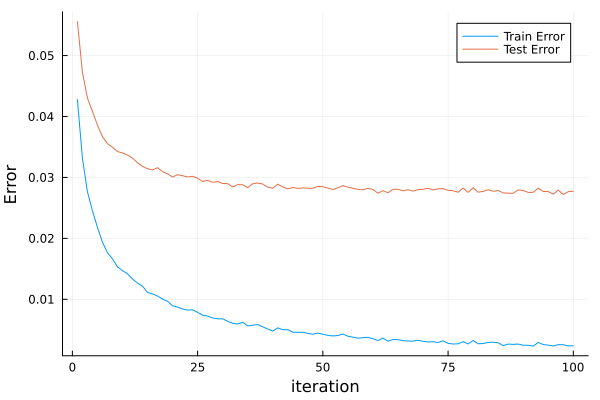

In [9]:
using Plots
plot(1:max_iteration, mse_train_dropout_list, label="Train Error", xlabel="iteration", ylabel="Error")
plot!(1:max_iteration, mse_test_dropout_list, label="Test Error", xlabel="iteration", ylabel="Error")

In [13]:
CSV.write("mse_train_dropout_list.csv", mse_train_dropout_list)
CSV.write("mse_test_dropout_list.csv", mse_test_dropout_list)

LoadError: ArgumentError: 'Vector{Any}' iterates 'Float64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

# MNISTでのドロップアウトを評価する
スクリプトなし

# バッチ勾配降下法

In [10]:
using LinearAlgebra, Statistics, Random
"""
データ
    訓練データ(特徴量)：flatten_x_train
    訓練データ(目的変数)：one_hot_label_y_train
"""

"""
パラメータ
"""
# 学習率
α = 0.005

# 入力層のサイズ
input_size = size(flatten_x_train)[2] # 784

# 隠れ層のサイズ
hidden_size = 300

# 出力層のサイズ
output_size = 10

W_0_1 = 0.2*rand(input_size, hidden_size).-0.1
W_1_2 = 0.2*rand(hidden_size, output_size).-0.1

# イテレーション
max_iteration = 100

# バッチサイズ
batch_size = 100

"""
関数
"""
relu(x) = (x>0)*x

relu2deriv(output) = output>0


"""
誤差逆伝播法
"""
# MSEを保存する用のリストを作成
mse_train_batch_list = []
mse_test_batch_list = []

for iteration=1:max_iteration
    for i in 1:Int(size(flatten_x_train)[1]/batch_size)-1
        batch_start = i*batch_size
        batch_end = (i+1)*batch_size
        
        # 順伝播
        layer_0 = flatten_x_train[batch_start:batch_end-1, :] # flatten_x_train[index, :]は横ベクトルで値を取得したはずが、縦ベクトルに勝手に変換されてしまう。そのため転置を行っている。
        layer_1_1 = layer_0*W_0_1 # 中間層の活性化関数に入れる前
        layer_1_2 = relu.(layer_1_1) # 中間層の活性化関数に入れた後

        # Dropoutを行う
        dropout_mask = reshape(rand(0:2, batch_size*size(layer_1_2)[2]), batch_size, size(layer_1_2)[2])
        layer_1_2 = layer_1_2.*dropout_mask
        layer_2 = layer_1_2*W_1_2

        # 更新式の差分
        ## layer_2のパラメータの更新式の差分
        ### layer_2ではなく、layer_2[1]としているのは、layer2が(1, 1)の行列になっているから
        layer_2_delta = layer_2-one_hot_label_y_train[batch_start:batch_end-1, :]
        W_1_2_delta = α*layer_1_2'*layer_2_delta # 次はここから直す

        ## layer_1のパラメータの更新式の差分
        layer_1_delta = (W_1_2*layer_2_delta'.*relu2deriv.(layer_1_1'))'
        layer_1_delta = layer_1_delta.*dropout_mask
        W_0_1_delta = α*reshape(layer_0, batch_size, 784)'*layer_1_delta

        # 更新
        W_1_2 = W_1_2-W_1_2_delta        
        W_0_1 = W_0_1-W_0_1_delta

        
    end
    # MSE(Mean Square Error)の計算
    ## 全てのデータに対して順伝播を行う
    ### 訓練データ
    Layer_1_1_train = flatten_x_train*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2_train = relu.(Layer_1_1_train) # 中間層の活性化関数に入れた後
    pred_list_train = Layer_1_2_train*W_1_2
    
    mse_train = mean((pred_list_train-one_hot_label_y_train).^2)
    push!(mse_train_batch_list, mse_train)
        
    ### テストデータ
    Layer_1_1_test = flatten_x_test*W_0_1 # 中間層の活性化関数に入れる前
    Layer_1_2_test = relu.(Layer_1_1_test) # 中間層の活性化関数に入れた後
    pred_list_test = Layer_1_2_test*W_1_2
    
    mse_test = mean((pred_list_test-one_hot_label_y_test).^2)
    push!(mse_test_batch_list, mse_test)
        
end

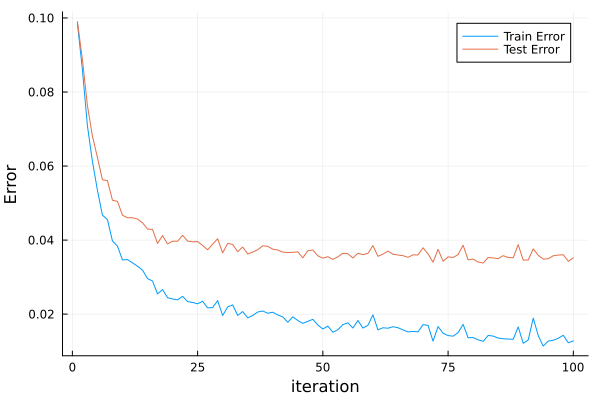

In [11]:
using Plots
plot(1:max_iteration, mse_train_batch_list, label="Train Error", xlabel="iteration", ylabel="Error")
plot!(1:max_iteration, mse_test_batch_list, label="Test Error", xlabel="iteration", ylabel="Error")

In [17]:
CSV.write("mse_train_batch_list.csv", Float16.(mse_train_batch_list))
CSV.write("mse_test_batch_list.csv", mse_test_batch_list)

LoadError: ArgumentError: 'Vector{Float16}' iterates 'Float16' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

In [19]:
Float16.(mse_train_batch_list)

100-element Vector{Float16}:
 0.09863
 0.08606
 0.0709
 0.06128
 0.05347
 0.04672
 0.04553
 0.03973
 0.03836
 0.03464
 0.03473
 0.03384
 0.03296
 ⋮
 0.01656
 0.01211
 0.01304
 0.01892
 0.01419
 0.011375
 0.01274
 0.01293
 0.01349
 0.014275
 0.01226
 0.012764